# Generate flux bar plot from Mass Balance file (.dat)

In [48]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import glob
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
from scipy import interpolate

In [4]:
def batch_time_to_delta(origin, x, time_format):
    y = []
    for ix in x:
        temp_y = abs(datetime.strptime(
            ix, time_format) - origin).total_seconds()
        y.append(temp_y)
    y = np.asarray(y)
    return(y)

def batch_delta_to_time(origin, x, time_format, delta_format):
    y = []
    for ix in x:
        if delta_format == "hours":
            temp_y = origin + timedelta(hours=ix)
        elif delta_format == "days":
            temp_y = origin + timedelta(days=ix)
        elif delta_format == "minutes":
            temp_y = origin + timedelta(minutes=ix)
        elif delta_format == "weeks":
            temp_y = origin + timedelta(weeks=ix)
        elif delta_format == "seconds":
            temp_y = origin + timedelta(seconds=ix)
        elif delta_format == "microseconds":
            temp_y = origin + timedelta(microseconds=ix)
        elif delta_format == "milliseconds":
            temp_y = origin + timedelta(milliseconds=ix)
        else:
            print("Sorry, this naive program only solve single time unit")
        y.append(temp_y.strftime(time_format))
    y = np.asarray(y)
    return(y)

In [77]:
# inputs
data_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/data/"
fname_usgs_gage = data_dir + "USGS_flow_gh_12472800.csv"
fname_mass1_coord = data_dir + "MASS1/coordinates.csv"
fname_river_middle = data_dir + "river_middle.csv"
fname_river_north = data_dir + "river_north.csv"
fname_river_south = data_dir + "river_south.csv"

model_dir = "/Users/shua784/Paraview/HFR/HFR_200x200x2_1w_bc/"
fname_model_origin = model_dir + "model_origin.txt"
fname_material_h5 = model_dir + "HFR_material_river.h5"
fname_pflotran_h5 = model_dir + "pflotran*.h5"
fname_mass_dat = model_dir + "*mas.dat"

# outputs
out_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/Outputs/HFR_model_200x200x2_1w_bc/"
fig_finger_flux = out_dir + "mass_balance/finger_flux.png"
fig_net_exchange_bar = out_dir + "mass_balance/net_exchange.png"
fname_net_exchange_txt = out_dir + "mass_balance/net_exchange.txt"
fig_flux_snapshot = out_dir + "mass_balance/"
fig_block_middle_flux_snapshot = out_dir + "flux_block_middle/"
fig_block_north_flux_snapshot = out_dir + "flux_block_north/"
fig_block_south_flux_snapshot = out_dir + "flux_block_south/"

In [11]:
date_origin = datetime.strptime("2007-03-28 00:00:00", "%Y-%m-%d %H:%M:%S")
model_origin = np.genfromtxt(
    fname_model_origin, delimiter=" ", skip_header=1)
material_file = h5.File(fname_material_h5, "r")

In [78]:
# middle block
block_middle_coord = np.genfromtxt(fname_river_middle, delimiter=",", skip_header=1)
block_middle_x = [(np.min(block_middle_coord[:, 1]) - model_origin[0]) / 1000,
           (np.max(block_middle_coord[:, 1]) - model_origin[0]) / 1000]

block_middle_y = [(np.min(block_middle_coord[:, 2]) - model_origin[1]) / 1000,
           (np.max(block_middle_coord[:, 2]) - model_origin[1]) / 1000]
# north block
block_north_coord = np.genfromtxt(fname_river_north, delimiter=",", skip_header=1)
block_north_x = [(np.min(block_north_coord[:, 1]) - model_origin[0]) / 1000,
           (np.max(block_north_coord[:, 1]) - model_origin[0]) / 1000]

block_north_y = [(np.min(block_north_coord[:, 2]) - model_origin[1]) / 1000,
           (np.max(block_north_coord[:, 2]) - model_origin[1]) / 1000]
# south block
block_south_coord = np.genfromtxt(fname_river_south, delimiter=",", skip_header=1)
block_south_x = [(np.min(block_south_coord[:, 1]) - model_origin[0]) / 1000,
           (np.max(block_south_coord[:, 1]) - model_origin[0]) / 1000]

block_south_y = [(np.min(block_south_coord[:, 2]) - model_origin[1]) / 1000,
           (np.max(block_south_coord[:, 2]) - model_origin[1]) / 1000]

In [24]:
discharge_file = open(fname_usgs_gage, "r")
discharge_data = discharge_file.readlines()
# print(discharge_data)

In [25]:
discharge_data = [x.replace('"', "") for x in discharge_data]
discharge_data = [x.split(",") for x in discharge_data[1:]]
discharge_data = [list(filter(None, x)) for x in discharge_data]
discharge_data = np.asarray(discharge_data)
discharge_time = [datetime.strptime(x, "%Y-%m-%d")
                  for x in discharge_data[:, 3]]
discharge_value = discharge_data[:, 4]  # .astype(float)

In [26]:
print(discharge_data[0:9])

[['1' 'USGS' '12472800' '1917-10-01' '77500' 'A' 'NA' 'NA\n']
 ['2' 'USGS' '12472800' '1917-10-02' '76600' 'A' 'NA' 'NA\n']
 ['3' 'USGS' '12472800' '1917-10-03' '75700' 'A' 'NA' 'NA\n']
 ['4' 'USGS' '12472800' '1917-10-04' '75700' 'A' 'NA' 'NA\n']
 ['5' 'USGS' '12472800' '1917-10-05' '74000' 'A' 'NA' 'NA\n']
 ['6' 'USGS' '12472800' '1917-10-06' '73100' 'A' 'NA' 'NA\n']
 ['7' 'USGS' '12472800' '1917-10-07' '73100' 'A' 'NA' 'NA\n']
 ['8' 'USGS' '12472800' '1917-10-08' '74000' 'A' 'NA' 'NA\n']
 ['9' 'USGS' '12472800' '1917-10-09' '75700' 'A' 'NA' 'NA\n']]


In [27]:
# read model dimensions
all_h5 = glob.glob(fname_pflotran_h5)
all_h5 = np.sort(all_h5)

input_h5 = h5.File(all_h5[0], "r")
x_grids = list(input_h5["Coordinates"]['X [m]'])
y_grids = list(input_h5["Coordinates"]['Y [m]'])
z_grids = list(input_h5["Coordinates"]['Z [m]'])
input_h5.close()

# x_grids = np.arange(0, 60001, 100)
# y_grids = np.arange(0, 60001, 100)
# z_grids = np.arange(0, 201, 5)

dx = np.diff(x_grids)
dy = np.diff(y_grids)
dz = np.diff(z_grids)

nx = len(dx)
ny = len(dy)
nz = len(dz)
x = x_grids[0] + np.cumsum(dx) - 0.5 * dx[0]
y = y_grids[0] + np.cumsum(dy) - 0.5 * dy[0]
z = z_grids[0] + np.cumsum(dz) - 0.5 * dz[0]

grids = np.asarray([(x, y, z) for z in range(nz)
                    for y in range(ny) for x in range(nx)])

west_area = dy[0] * dz[0]
east_area = dy[0] * dz[0]
south_area = dx[0] * dz[0]
north_area = dx[0] * dz[0]
top_area = dx[0] * dy[0]
bottom_area = dx[0] * dy[0]

In [28]:
# read river section information
mass1_sections = [s for s, s in enumerate(
    list(material_file["Regions"].keys())) if "Mass1" in s]
group_order = np.argsort(np.asarray(
    [x[6:] for x in mass1_sections]).astype(float))
mass1_sections = [mass1_sections[i] for i in group_order]
nsection = len(mass1_sections)
section_area = []
for isection in mass1_sections:
    faces = list(material_file["Regions"][isection]['Face Ids'])
    iarea = faces.count(1) * west_area + faces.count(2) * east_area + \
        faces.count(3) * south_area + faces.count(4) * north_area + \
        faces.count(5) * bottom_area + faces.count(6) * bottom_area
    section_area.append(iarea)
section_area = np.asarray(section_area)


In [29]:
# read mass1 coordinates
section_coord = np.genfromtxt(
    fname_mass1_coord, delimiter=",", skip_header=1)

section_coord[:, 1] = section_coord[:, 1] - model_origin[0]
section_coord[:, 2] = section_coord[:, 2] - model_origin[1]
# subtract last mass1 location to get length for each segment
mass1_length = section_coord[:, 4] - section_coord[-1, 4]


In [30]:
print(section_coord)

[[4.0000000e+01 6.7779280e+03 4.1031487e+04 3.8832000e+02 6.2494000e+02]
 [4.1000000e+01 6.9801640e+03 4.1177211e+04 3.8816700e+02 6.2469400e+02]
 [4.2000000e+01 7.1977160e+03 4.1335660e+04 3.8800200e+02 6.2442900e+02]
 ...
 [3.3100000e+02 4.3688907e+04 9.5392540e+03 3.4314600e+02 5.5224000e+02]
 [3.3200000e+02 4.3724264e+04 9.3031000e+03 3.4299500e+02 5.5199700e+02]
 [3.3300000e+02 4.3779585e+04 9.0653260e+03 3.4284300e+02 5.5175200e+02]]


In [31]:
# add three lines to contour indicating mass1 location
line1 = section_coord[0, 1:3] / 1000
line2 = section_coord[int(len(section_coord[:, 1]) / 2), 1:3] / 1000
line3 = section_coord[-1, 1:3] / 1000
line1_x = [line1[0]] * 2
line1_y = [line1[1] - 5, line1[1] + 5]
line2_x = [line2[0] - 5, line2[0] + 5]
line2_y = [line2[1]] * 2
line3_x = [line3[0] - 5, line3[0] + 5]
line3_y = [line3[1]] * 2

In [32]:
# read mass balance data
mass_file = open(glob.glob(fname_mass_dat)[0], "r")
mass_data = mass_file.readlines()
mass_header = mass_data[0].replace('"', '').split(",")
mass_header = list(filter(None, mass_header))
mass_data = [x.split(" ") for x in mass_data[1:]]
mass_data = [list(filter(None, x)) for x in mass_data]
mass_data = np.asarray(mass_data).astype(float)

In [42]:
print(mass_header[0:20])
print(mass_data[0])

[' Time [h]', 'dt_flow [h]', 'dt_tran [h]', 'Global Water Mass [kg]', 'Global Tracer [mol]', 'Global Tracer_Age [mol]', 'River_40 Water Mass [kg]', 'River_40 Water Mass [kg/h]', 'River_40 Tracer [mol]', 'River_40 Tracer_Age [mol]', 'River_40 Tracer [mol/h]', 'River_40 Tracer_Age [mol/h]', 'River_41 Water Mass [kg]', 'River_41 Water Mass [kg/h]', 'River_41 Tracer [mol]', 'River_41 Tracer_Age [mol]', 'River_41 Tracer [mol/h]', 'River_41 Tracer_Age [mol/h]', 'River_42 Water Mass [kg]', 'River_42 Water Mass [kg/h]']
[ 3.24000000e+04  1.45312500e+00  1.45312500e+00 ... -3.51599024e+15
 -3.64919824e+05 -8.06420568e+12]


In [40]:
# find columns of desired mass1 colmns
# e.g River_40 Water Mass [kg]
mass_index = [i for i, s in enumerate(mass_header) if (
    "River" in s and "Water" in s and "kg]" in s)]
# e.g River_40 Water Mass [kg/h]
flux_index = [i for i, s in enumerate(mass_header) if (
    "River" in s and "Water" in s and "kg/h" in s)]


In [43]:
# get total river mass/flux across the river bed
total_mass = np.sum(mass_data[:, mass_index], axis=1).flatten()
total_flux = np.sum(mass_data[:, flux_index], axis=1).flatten()

In [44]:
# shift mass when restart happened, new starting mass would shift to zero
diff_total_mass = abs(np.diff(total_mass))
restart_index = np.arange(len(diff_total_mass))[diff_total_mass > 2e10]

for i_restart_index in restart_index:
    total_mass[(i_restart_index + 1):len(total_mass)] = total_mass[(
        i_restart_index + 1):len(total_mass)] + total_mass[restart_index]

## plot finger flux

In [45]:
# plot fingerprint plots
simu_time = mass_data[:, 0]
real_time = batch_delta_to_time(
    date_origin, simu_time, "%Y-%m-%d %H:%M:%S", "hours")
real_time = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in real_time]
plot_time = [
    "2011-01-01 00:00:00",
    "2016-01-01 00:00:00"]
plot_time = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in plot_time]
time_ticks = [
    "2011-01-01 00:00:00",
    "2012-01-01 00:00:00",
    "2013-01-01 00:00:00",
    "2014-01-01 00:00:00",
    "2015-01-01 00:00:00",
    "2016-01-01 00:00:00"]
time_ticks = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in time_ticks]

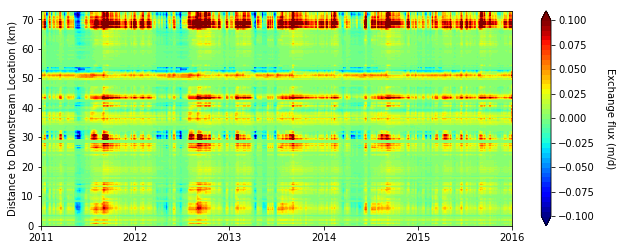

In [50]:
flux_array = mass_data[:, flux_index]
flux_array = np.asarray(flux_array) / 1000 * 24
for itime in range(len(real_time)):
    flux_array[itime, :] = flux_array[itime, :] / section_area

# plot finger flux
fig_name = fig_finger_flux
gs = gridspec.GridSpec(1, 1)
fig = plt.figure()
ax1 = fig.add_subplot(gs[0, 0])
cf1 = ax1.contourf(real_time,
                   0.5 * (mass1_length[1:] + mass1_length[:-1]),
                   -np.transpose(flux_array),
                   cmap=plt.cm.jet,
                   levels=np.arange(-0.1, 0.105, 0.005),
                   extend="both",
                   )
ax1.set_ylabel("")
ax1.set_ylabel("Distance to Downstream Location (km)")
ax1.set_xticks(time_ticks)
ax1.set_ylim([0, 7.3e1])
ax1.set_xlim([time_ticks[0], time_ticks[-1]])
cb1 = plt.colorbar(cf1, extend="both")
cb1.ax.set_ylabel("Exchange flux (m/d)", rotation=270, labelpad=20)
fig.tight_layout()
fig.set_size_inches(10, 3.5)

In [52]:
# fig.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [46]:
fig.savefig(fig_name, dpi=600, transparent=True)
plt.close(fig)

In [53]:
# calculate net mass
n_segment = len(time_ticks) - 1
sum_mass = np.array([0.] * n_segment)
all_mass = np.array([0.] * n_segment)
for i_segment in range(n_segment):
    select_index = []
    for i_index in range(len(real_time)):
        if (real_time[i_index] >= time_ticks[i_segment] and
                real_time[i_index] < time_ticks[i_segment + 1]):
            select_index.append(i_index)
    sum_mass[i_segment] = total_mass[select_index[-1]] - \
        total_mass[select_index[0] - 1]
    time_inverval = real_time[select_index[-1]] - real_time[select_index[0] - 1]
    time_scale = 365.25 * 24 * 3600 / time_inverval.total_seconds()
    sum_mass[i_segment] = sum_mass[i_segment] * time_scale / 1000

abs_mass = np.array([0.] * n_segment)
out_mass = np.array([0.] * n_segment)
in_mass = np.array([0.] * n_segment)

In [54]:
# calculate dam discharge
discharge_flow = np.array([0.] * n_segment)
for i_segment in range(n_segment):
    select_index = []
    for i_index in range(len(discharge_time)):
        if (discharge_time[i_index] >= time_ticks[i_segment] and
                discharge_time[i_index] < time_ticks[i_segment + 1]):
            select_index.append(i_index)
    sum_discharge = sum(np.asarray([discharge_value[i]
                                    for i in select_index]).astype(float))
    sum_discharge = sum_discharge * 3600 * 24 * (0.3048**3)
    # print("{:.5E}".format(sum_discharge))
    discharge_flow[i_segment] = sum_discharge

## plot net exchange bar plot

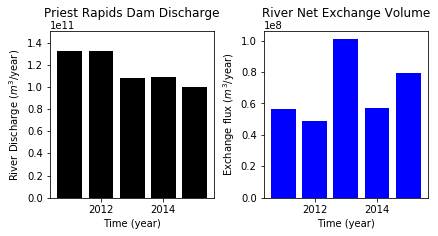

In [56]:
## plot bar plots for net gaining volumn
# plot dam discharge
start_year = 2011
fig_name = fig_net_exchange_bar
gs = gridspec.GridSpec(1, 2)
fig = plt.figure()
ax0 = fig.add_subplot(gs[0, 0])
ax0.bar(start_year + np.arange(n_segment), discharge_flow, color="black")
ax0.set_ylim([0, 1.5e11])
ax0.set_xlabel('Time (year)')
ax0.set_ylabel('River Discharge ($m^3$/year)')
ax0.set_title("Priest Rapids Dam Discharge", y=1.05)

# plot net exchange
ax1 = fig.add_subplot(gs[0, 1])
ax1.bar(start_year + np.arange(n_segment), -sum_mass, color="blue")
#ax1.set_ylim([0, 1e8])
ax1.set_xlabel('Time (year)')
ax1.set_ylabel('Exchange flux ($m^3$/year)')
ax1.set_title("River Net Exchange Volume", y=1.05)
fig.tight_layout()
fig.subplots_adjust(left=0.2,
                    right=0.95,
                    bottom=0.08,
                    top=0.85,
                    wspace=0.30,
                    hspace=0.38
                    )
fig.set_size_inches(7, 3)
# fig.savefig(fig_name, dpi=600, transparent=True)

In [55]:
fig.savefig(fig_name, dpi=600)
plt.close(fig)

In [63]:
# a = -sum_mass
np.savetxt(fname_net_exchange_txt, -sum_mass, fmt = '%.2e')


In [69]:
range(len(real_time[0:1]))

range(0, 1)

## plot flux exchange across riverbed snapshots

0


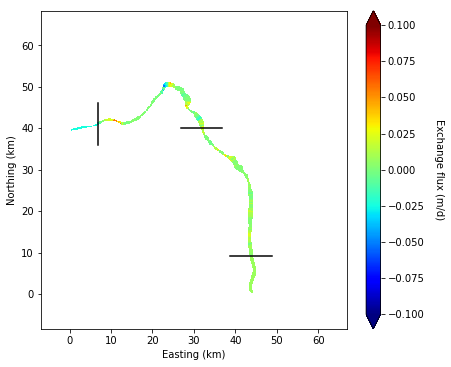

In [74]:
## plot exchange flux accross riverbed snapshots
for itime in range(len(real_time[0:1])):
    print(itime)
    yx_flux = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
    for isection in range(len(mass1_sections)):
        # need minus 1 as python index started with 0
        cell_ids = list(material_file["Regions"]
                        [mass1_sections[isection]]['Cell Ids'])
        cell_ids = (np.asarray(cell_ids) - 1).astype(int)
        xy_cell_index = [grids[i, 0:2] for i in cell_ids]
        xy_cell_index = np.unique(xy_cell_index, axis=0)
        for iindex in range(len(xy_cell_index)):
            yx_flux[xy_cell_index[iindex][1],
                    xy_cell_index[iindex][0]] = flux_array[itime, isection]
    fig_name = fig_flux_snapshot + str(real_time[itime]) + ".png"
    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(line1_x, line1_y, "black")
    ax1.plot(line2_x, line2_y, "black")
    ax1.plot(line3_x, line3_y, "black")
    cf1 = ax1.imshow(-yx_flux,
                     cmap=plt.cm.jet,
                     origin="lower",
                     vmin=-0.1,
                     vmax=0.1,
                     extent=[(x[0] - 0.5 * dx[0]) / 1000,
                             (x[-1] + 0.5 * dx[0]) / 1000,
                             (y[0] - 0.5 * dy[0]) / 1000,
                             (y[-1] + 0.5 * dy[0]) / 1000]
                     )
    ax1.set_xlabel("Easting (km)")
    ax1.set_ylabel("Northing (km)")
    ax1.set_aspect("equal", "datalim")
    ax1.set_xlim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    ax1.set_ylim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    cb1 = plt.colorbar(cf1, extend="both")
    cb1.ax.set_ylabel("Exchange flux (m/d)", rotation=270, labelpad=20)
    fig.tight_layout()
    fig.set_size_inches(6.5, 5.5)
#     fig.savefig(fig_name, dpi=600)
#     plt.close(fig)    

In [75]:
    fig.savefig(fig_name, dpi=600)
    plt.close(fig)

## plot flux exchange across riverbed snapshots for _north block_

2010-12-07 00:00:00


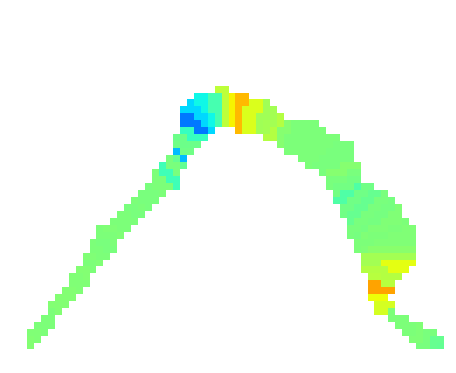

In [80]:
for itime in range(len(real_time[0:1])):
    print(real_time[itime])
    yx_flux = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
    for isection in range(len(mass1_sections)):
        # need minus 1 as python index started with 0
        cell_ids = list(material_file["Regions"]
                        [mass1_sections[isection]]['Cell Ids'])
        cell_ids = (np.asarray(cell_ids) - 1).astype(int)
        xy_cell_index = [grids[i, 0:2] for i in cell_ids]
        xy_cell_index = np.unique(xy_cell_index, axis=0)
        for iindex in range(len(xy_cell_index)):
            yx_flux[xy_cell_index[iindex][1],
                    xy_cell_index[iindex][0]] = flux_array[itime, isection]
    fig_name = fig_block_north_flux_snapshot + str(real_time[itime]) + ".png"
    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0])
    cf1 = ax1.imshow(-yx_flux,
                     cmap=plt.cm.jet,
                     origin="lower",
                     vmin=-0.1,
                     vmax=0.1,
                     extent=[(x[0] - 0.5 * dx[0]) / 1000,
                             (x[-1] + 0.5 * dx[0]) / 1000,
                             (y[0] - 0.5 * dy[0]) / 1000,
                             (y[-1] + 0.5 * dy[0]) / 1000]
                     )
    ax1.axis("off")
    ax1.set_aspect("equal", "datalim")
    ax1.set_xlim(block_north_x)
    ax1.set_ylim(block_north_y)
    # ax1.set_xlabel("Easting (km)")
    # ax1.set_ylabel("Northing (km)")
    fig.tight_layout()
    fig.set_size_inches(6.5, 5.5)
#     fig.savefig(fig_name, dpi=600)
#     plt.close(fig)

In [81]:
    fig.savefig(fig_name, dpi=600)
    plt.close(fig)

## plot flux exchange across riverbed snapshots for _middle block_

2010-12-07 00:00:00


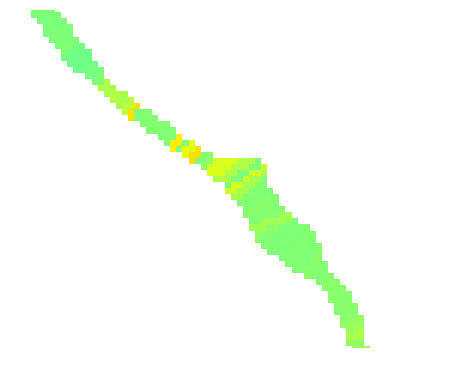

In [82]:
for itime in range(len(real_time[0:1])):
    print(real_time[itime])
    yx_flux = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
    for isection in range(len(mass1_sections)):
        # need minus 1 as python index started with 0
        cell_ids = list(material_file["Regions"]
                        [mass1_sections[isection]]['Cell Ids'])
        cell_ids = (np.asarray(cell_ids) - 1).astype(int)
        xy_cell_index = [grids[i, 0:2] for i in cell_ids]
        xy_cell_index = np.unique(xy_cell_index, axis=0)
        for iindex in range(len(xy_cell_index)):
            yx_flux[xy_cell_index[iindex][1],
                    xy_cell_index[iindex][0]] = flux_array[itime, isection]
    fig_name = fig_block_middle_flux_snapshot + str(real_time[itime]) + ".png"
    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0])
    cf1 = ax1.imshow(-yx_flux,
                     cmap=plt.cm.jet,
                     origin="lower",
                     vmin=-0.1,
                     vmax=0.1,
                     extent=[(x[0] - 0.5 * dx[0]) / 1000,
                             (x[-1] + 0.5 * dx[0]) / 1000,
                             (y[0] - 0.5 * dy[0]) / 1000,
                             (y[-1] + 0.5 * dy[0]) / 1000]
                     )
    ax1.axis("off")
    ax1.set_aspect("equal", "datalim")
    ax1.set_xlim(block_middle_x)
    ax1.set_ylim(block_middle_y)
    # ax1.set_xlabel("Easting (km)")
    # ax1.set_ylabel("Northing (km)")
    fig.tight_layout()
    fig.set_size_inches(6.5, 5.5)
#     fig.savefig(fig_name, dpi=600)
#     plt.close(fig)

In [83]:
    fig.savefig(fig_name, dpi=600)
    plt.close(fig)

## plot flux exchange across riverbed snapshots for _south block_

2010-12-07 00:00:00


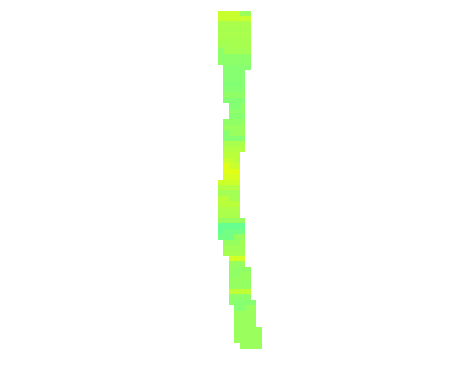

In [84]:
for itime in range(len(real_time[0:1])):
    print(real_time[itime])
    yx_flux = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
    for isection in range(len(mass1_sections)):
        # need minus 1 as python index started with 0
        cell_ids = list(material_file["Regions"]
                        [mass1_sections[isection]]['Cell Ids'])
        cell_ids = (np.asarray(cell_ids) - 1).astype(int)
        xy_cell_index = [grids[i, 0:2] for i in cell_ids]
        xy_cell_index = np.unique(xy_cell_index, axis=0)
        for iindex in range(len(xy_cell_index)):
            yx_flux[xy_cell_index[iindex][1],
                    xy_cell_index[iindex][0]] = flux_array[itime, isection]
    fig_name = fig_block_south_flux_snapshot + str(real_time[itime]) + ".png"
    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0])
    cf1 = ax1.imshow(-yx_flux,
                     cmap=plt.cm.jet,
                     origin="lower",
                     vmin=-0.1,
                     vmax=0.1,
                     extent=[(x[0] - 0.5 * dx[0]) / 1000,
                             (x[-1] + 0.5 * dx[0]) / 1000,
                             (y[0] - 0.5 * dy[0]) / 1000,
                             (y[-1] + 0.5 * dy[0]) / 1000]
                     )
    ax1.axis("off")
    ax1.set_aspect("equal", "datalim")
    ax1.set_xlim(block_south_x)
    ax1.set_ylim(block_south_y)
    # ax1.set_xlabel("Easting (km)")
    # ax1.set_ylabel("Northing (km)")
    fig.tight_layout()
    fig.set_size_inches(6.5, 5.5)
#     fig.savefig(fig_name, dpi=600)
#     plt.close(fig)

In [85]:
    fig.savefig(fig_name, dpi=600)
    plt.close(fig)